# Import

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set(context='talk', style='ticks', color_codes=True)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

from scipy.spatial import distance_matrix 
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

from IPython.display import display
from IPython.display import SVG, HTML
from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG = True  # Change output to SVG
# IPythonConsole.drawOptions.addAtomIndices = True

In [2]:
from UQtools import *

In [3]:
base_dir = os.path.dirname(os.path.realpath('__file__')).replace('/scripts/uncertaintyEstimates', '')
base_dir

'/Users/nicolairee/KU_data/esnuelML/ESNUEL_ML'

# Load data

In [4]:
df = pd.read_csv(os.path.join(base_dir, 'data/uncertaintyEstimates/elec_test_UQres.csv'))
print(df.shape[0])
df.head(2)

80118


,Y_true,Y_pred,Y_pred_RF,Y_pred_1KNN,Y_pred_10KNN,RF_DT_std,1KNNdistsP1,1KNNdistsP2,10KNNdistsP1,10KNNdistsP2
0,227.719619,245.100638,244.325396,246.171663,243.705019,10.905076,0.04168,0.022927,0.186169,0.093052
1,37.868317,12.719186,-2.937685,-14.287166,5.862365,37.554496,0.04096,0.019460,0.158695,0.079915


# Calculate UQ metrics

## LightGBM predictor

### RF_DT_std

In [123]:
sigmas = df['RF_DT_std']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
75355,1.167649,-0.913233,0.782113
24965,1.662266,-0.195057,0.117344


R-squared: 0.9945717661316246
Intercept: 4.3372205727670305
Slope: 0.6140308723543682


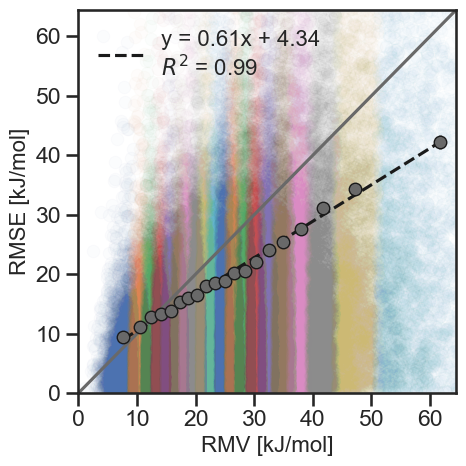

In [144]:
Nbins = 20
N_total = len(ordered_df['uq'])
N_entries = math.ceil(N_total/Nbins)

rmvs, rmses, ci_low, ci_high = get_rmvs_and_rmses(ordered_df['uq'], ordered_df['errors'], Nbins=Nbins, include_bootstrap=True)

x = np.array(rmvs)
y = np.array(rmses)

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
slope, intercept, r_value, p_value, std_err = ss.linregress(x, y)
r_sq = r_value**2
print('R-squared:', r_sq)

# Print the Intercept:
print('Intercept:', intercept)

# Print the Slope:
print('Slope:', slope) 

# Predict a Response and print it:
# y_pred = model.predict(x)
y_pred = slope * x + intercept

fig, ax = plt.subplots(figsize=(5, 5))
assymetric_errors = [np.array(rmses)-np.array(ci_low), np.array(ci_high)-np.array(rmses)]
ax.errorbar(x, y, yerr = assymetric_errors, fmt="o", color='dimgrey', markeredgecolor='k', linewidth=2)

if ax.get_xlim()[-1] > ax.get_ylim()[-1]:
    plt.xlim(0,ax.get_xlim()[-1])
    plt.ylim(0,ax.get_xlim()[-1])
    ax.plot(np.arange(0,ax.get_xlim()[-1],0.01),np.arange(0,ax.get_xlim()[-1],0.01), linestyle='-', color='dimgrey')
    plt.xticks(np.arange(0,ax.get_xlim()[-1]+1,10))
    plt.yticks(np.arange(0,ax.get_xlim()[-1]+1,10))
else:
    plt.xlim(0,ax.get_ylim()[-1])
    plt.ylim(0,ax.get_ylim()[-1])
    ax.plot(np.arange(0,ax.get_ylim()[-1],0.01),np.arange(0,ax.get_ylim()[-1],0.01), linestyle='-', color='dimgrey')
    plt.xticks(np.arange(0,ax.get_ylim()[-1]+1,10))
    plt.yticks(np.arange(0,ax.get_ylim()[-1]+1,10))


x2 = [ordered_df['uq'][i:i+N_entries].tolist() for i in range(0, N_total, N_entries)]
y2 = [abs(ordered_df['errors'][i:i+N_entries]).tolist() for i in range(0, N_total, N_entries)]
for i in range(Nbins):
    sns.scatterplot(x="x2", y="y2", data=pd.DataFrame(np.column_stack((x2[i],y2[i])), columns=["x2", "y2"]), markers='.', alpha=0.02, edgecolors=None, rasterized=True)
    # plt.plot(np.median(x2[i]),np.median(y2[i]), 'ro', markeredgecolor='k')

if intercept >= 0:
    ax.plot(rmvs, slope * np.array(rmvs) + intercept, linestyle="dashed", color='k', label="y = {:0.2f}".format(slope)+"x + {:0.2f}\n".format(intercept) + r'$R^2$ = '"{:0.2f}".format(r_sq))
else:
    ax.plot(rmvs, slope * np.array(rmvs) + intercept, linestyle="dashed", color='k', label="y = {:0.2f}".format(slope)+"x - {:0.2f}\n".format(intercept) + r'$R^2$ = '"{:0.2f}".format(r_sq))

ax.set_xlabel("RMV [kJ/mol]", fontsize=16)
ax.set_ylabel("RMSE [kJ/mol]", fontsize=16)
ax.legend(loc=2, fontsize=16, frameon=False)
if ax.get_xlim()[-1] > ax.get_ylim()[-1]:
    plt.xlim(0,ax.get_xlim()[-1])
    plt.ylim(0,ax.get_xlim()[-1])
else:
    plt.xlim(0,ax.get_ylim()[-1])
    plt.ylim(0,ax.get_ylim()[-1])

plt.tight_layout()
plt.savefig('figures/elec_RF_DT_std_slope_metric_withColoring.pdf')
plt.show()

miscalibration area = 0.10
R-squared: 0.9945717661316246
Intercept: 4.3372205727670305
Slope: 0.6140308723543682


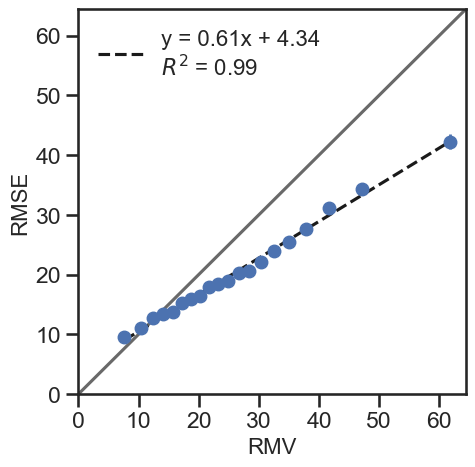

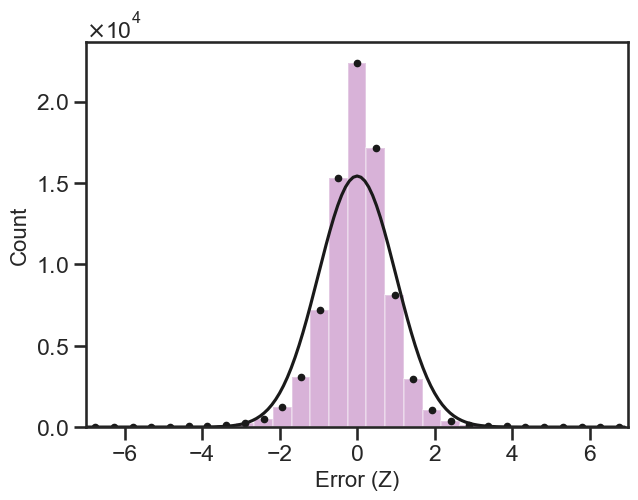

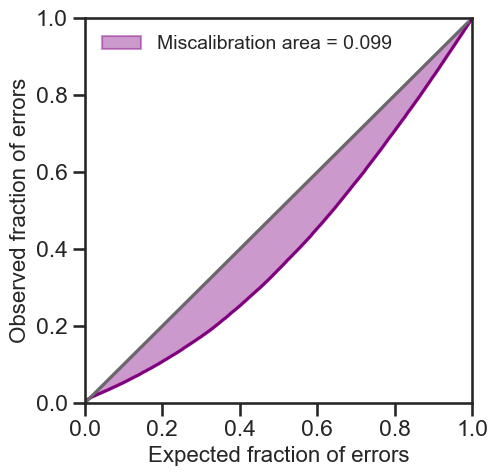

In [81]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [7]:
fig1.tight_layout()
fig1.savefig('figures/elec_RF_DT_std_slope_metric.pdf')

fig2.tight_layout()
fig2.savefig('figures/elec_RF_DT_std_Z_scores.pdf')

fig3.tight_layout()
fig3.savefig('figures/elec_RF_DT_std_calibration_curve.pdf')

In [185]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.36
rho_rank_sim = 0.47 +/- 0.00
NLL = 4.42
NLL_sim = 4.56 +/- 0.00


### 1KNNdistsP1

In [104]:
sigmas = df['1KNNdistsP1']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
61882,0.0,-0.215037,inf
76829,0.0,-9.638032,inf


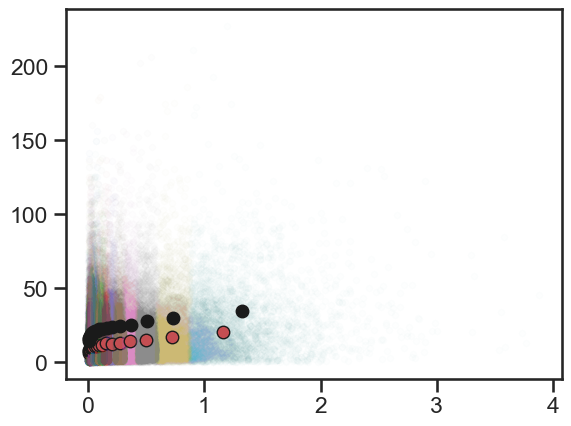

In [106]:
Nbins = 20
N_total = len(ordered_df['uq'])
N_entries = math.ceil(N_total/Nbins)
rmvs = [np.sqrt((ordered_df['uq'][i:i+N_entries]**2).mean()) for i in range(0, N_total, N_entries)]
rmses = [np.sqrt((ordered_df['errors'][i:i+N_entries]**2).mean()) for i in range(0, N_total, N_entries)]

x2 = [ordered_df['uq'][i:i+N_entries].tolist() for i in range(0, N_total, N_entries)]
y2 = [abs(ordered_df['errors'][i:i+N_entries]).tolist() for i in range(0, N_total, N_entries)]

for i in range(Nbins):
    plt.plot(x2[i],y2[i], '.', alpha=0.01, markeredgecolor=None)
    plt.plot(np.median(x2[i]),np.median(y2[i]), 'ro', markeredgecolor='k')

# plt.xlim(0,80)
# plt.ylim(0,140)
plt.plot(rmvs,rmses, 'ko')
plt.show()

miscalibration area = 0.49
R-squared: 0.8247807498454315
Intercept: 18.596327504112875
Slope: 14.223681087145124


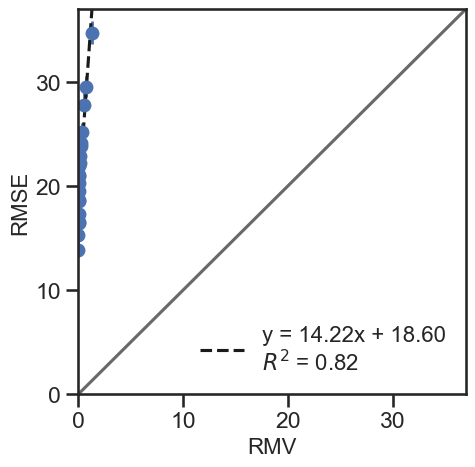

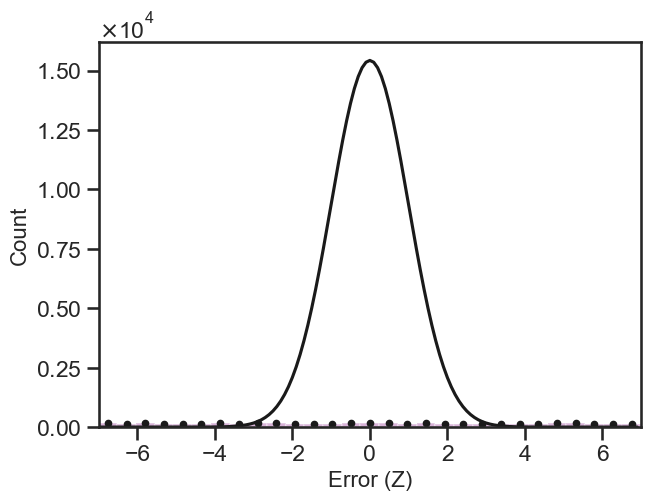

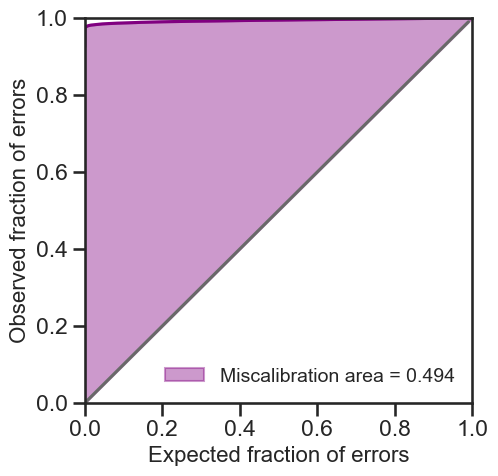

In [187]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [188]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')
# exp_NLL = []
# for i in range(1000):
#     sim_errors = []
#     for sigma in ordered_df.uq:
#         sim_error = np.random.normal(0, sigma)
#         sim_errors.append(sim_error)
#     NLL_sim = NLL(ordered_df.uq, sim_errors)
#     exp_NLL.append(NLL_sim)
# NLL_sim = np.mean(exp_NLL)
# NLL_sim_std = np.std(exp_NLL)
# print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.24
rho_rank_sim = 0.84 +/- 0.00


ValueError: math domain error

### 1KNNdistsP2

In [189]:
sigmas = df['1KNNdistsP2']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
61882,0.0,-0.215037,inf
76829,0.0,-9.638032,inf


miscalibration area = 0.50
R-squared: 0.8476515017734345
Intercept: 18.22962504022486
Slope: 39.426373287327024


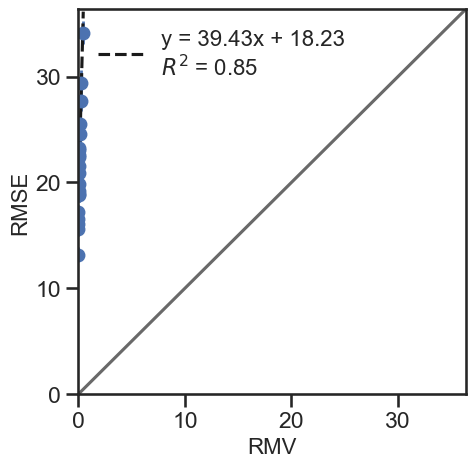

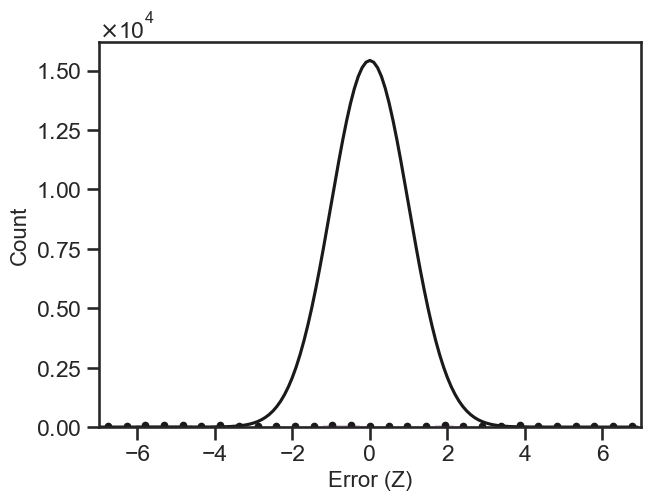

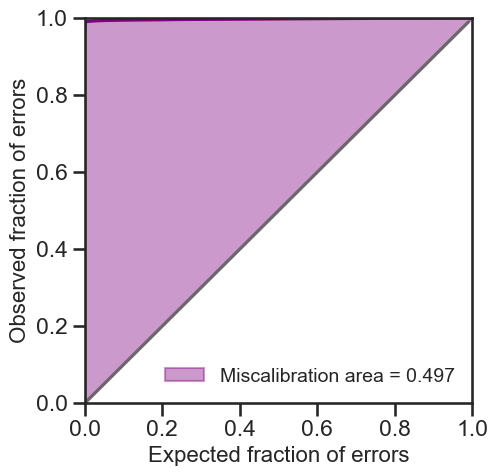

In [190]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [191]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')
# exp_NLL = []
# for i in range(1000):
#     sim_errors = []
#     for sigma in ordered_df.uq:
#         sim_error = np.random.normal(0, sigma)
#         sim_errors.append(sim_error)
#     NLL_sim = NLL(ordered_df.uq, sim_errors)
#     exp_NLL.append(NLL_sim)
# NLL_sim = np.mean(exp_NLL)
# NLL_sim_std = np.std(exp_NLL)
# print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.24
rho_rank_sim = 0.84 +/- 0.00


ValueError: math domain error

### 10KNNdistsP1

In [192]:
sigmas = df['10KNNdistsP1']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
70714,0.001354,-5.075689,3748.662439
61524,0.001510,6.297523,4170.544916


miscalibration area = 0.49
R-squared: 0.962199096418275
Intercept: 18.06989370677949
Slope: 9.405708899155025


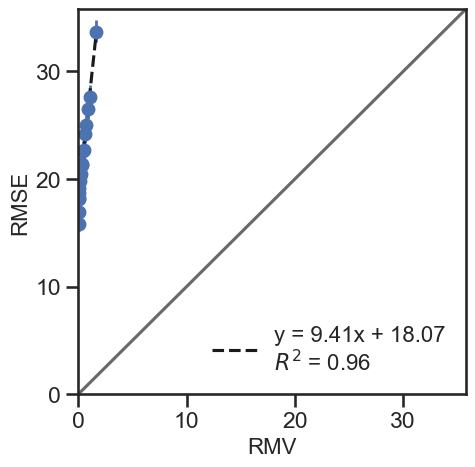

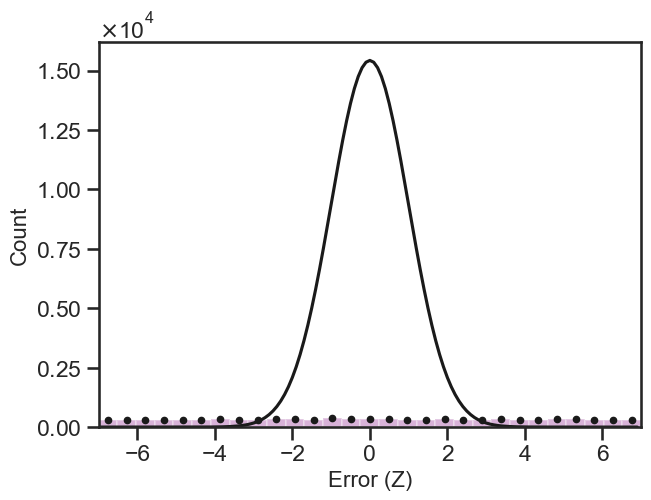

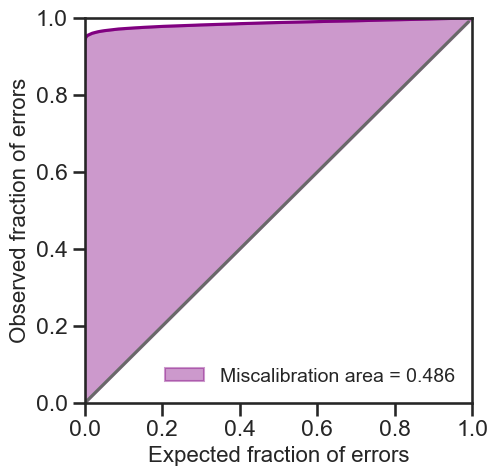

In [193]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [194]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.19
rho_rank_sim = 0.79 +/- 0.00
NLL = 124289.26
NLL_sim = -0.26 +/- 0.00


### 10KNNdistsP2

In [195]:
sigmas = df['10KNNdistsP2']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
70714,0.000499,-5.075689,10163.985795
1101,0.000555,-3.650163,6573.528555


miscalibration area = 0.49
R-squared: 0.9681360384138004
Intercept: 17.748684280867817
Slope: 26.12586403575893


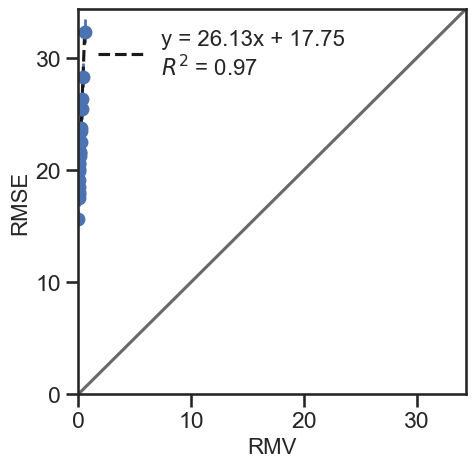

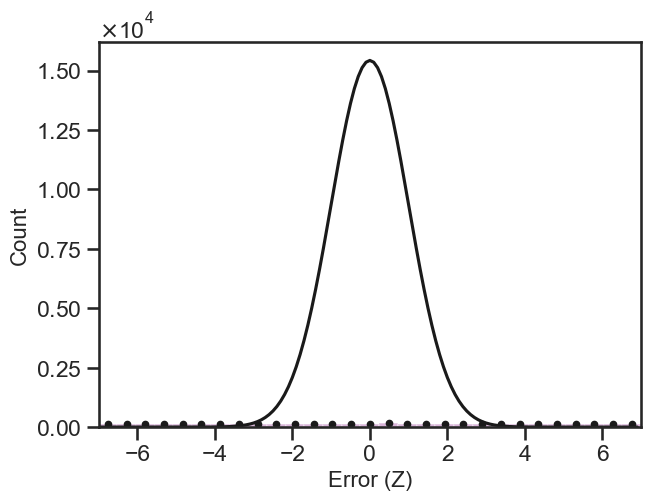

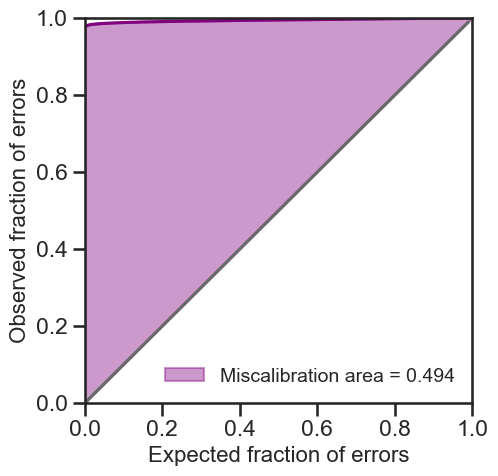

In [196]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [197]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.18
rho_rank_sim = 0.78 +/- 0.00
NLL = 730210.69
NLL_sim = -1.12 +/- 0.00


### Pred. std

In [107]:
sigmas = np.std(list(zip(df['Y_pred'], df['Y_pred_RF'], df['Y_pred_1KNN'], df['Y_pred_10KNN'])), ddof=1, axis=1)
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
5687,0.116009,9.699985,83.613935
67939,0.152290,11.794954,77.450634


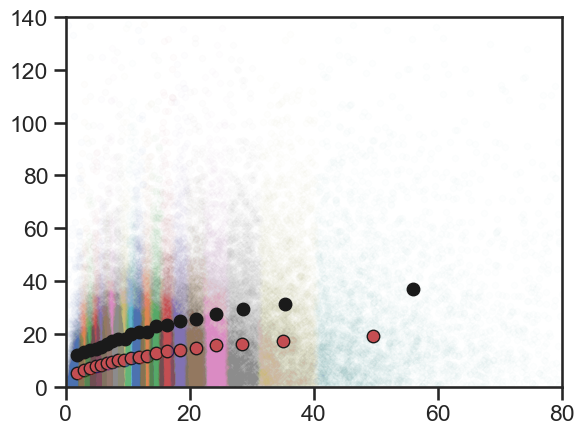

In [108]:
Nbins = 20
N_total = len(ordered_df['uq'])
N_entries = math.ceil(N_total/Nbins)
rmvs = [np.sqrt((ordered_df['uq'][i:i+N_entries]**2).mean()) for i in range(0, N_total, N_entries)]
rmses = [np.sqrt((ordered_df['errors'][i:i+N_entries]**2).mean()) for i in range(0, N_total, N_entries)]

x2 = [ordered_df['uq'][i:i+N_entries].tolist() for i in range(0, N_total, N_entries)]
y2 = [abs(ordered_df['errors'][i:i+N_entries]).tolist() for i in range(0, N_total, N_entries)]

for i in range(Nbins):
    plt.plot(x2[i],y2[i], '.', alpha=0.01, markeredgecolor=None)
    plt.plot(np.median(x2[i]),np.median(y2[i]), 'ro', markeredgecolor='k')

plt.xlim(0,80)
plt.ylim(0,140)
plt.plot(rmvs,rmses, 'ko')
plt.show()

miscalibration area = 0.12
R-squared: 0.9267879614573367
Intercept: 13.64717080322843
Slope: 0.4929653633258078


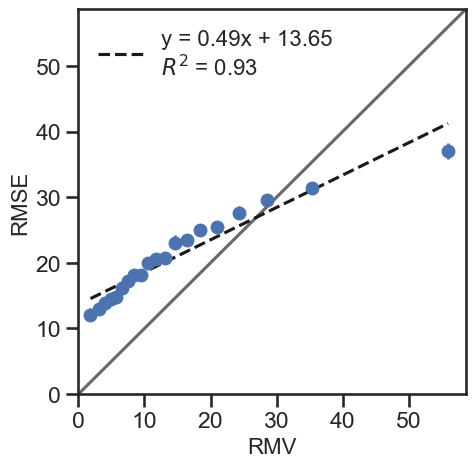

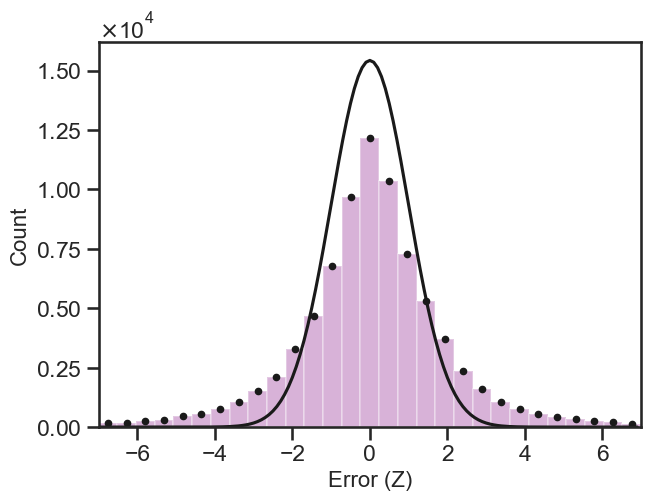

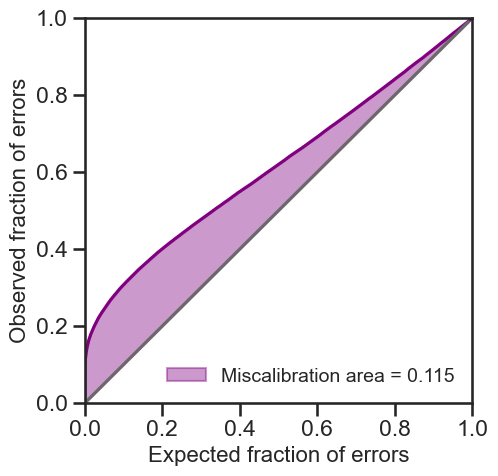

In [199]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [200]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.31
rho_rank_sim = 0.64 +/- 0.00
NLL = 8.21
NLL_sim = 3.79 +/- 0.00


## Random forest predictor

### RF_DT_std

In [109]:
sigmas = df['RF_DT_std']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
75355,1.167649,-1.400574,1.199483
24965,1.662266,-0.395751,0.238079


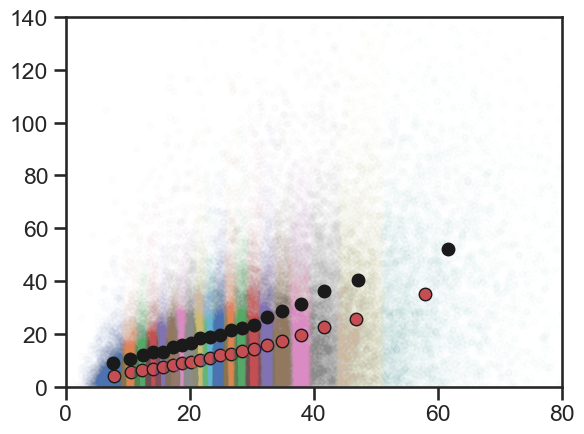

In [110]:
Nbins = 20
N_total = len(ordered_df['uq'])
N_entries = math.ceil(N_total/Nbins)
rmvs = [np.sqrt((ordered_df['uq'][i:i+N_entries]**2).mean()) for i in range(0, N_total, N_entries)]
rmses = [np.sqrt((ordered_df['errors'][i:i+N_entries]**2).mean()) for i in range(0, N_total, N_entries)]

x2 = [ordered_df['uq'][i:i+N_entries].tolist() for i in range(0, N_total, N_entries)]
y2 = [abs(ordered_df['errors'][i:i+N_entries]).tolist() for i in range(0, N_total, N_entries)]

for i in range(Nbins):
    plt.plot(x2[i],y2[i], '.', alpha=0.01, markeredgecolor=None)
    plt.plot(np.median(x2[i]),np.median(y2[i]), 'ro', markeredgecolor='k')

plt.xlim(0,80)
plt.ylim(0,140)
plt.plot(rmvs,rmses, 'ko')
plt.show()

miscalibration area = 0.08
R-squared: 0.9892094996474332
Intercept: 0.830370144329649
Slope: 0.8106844065697405


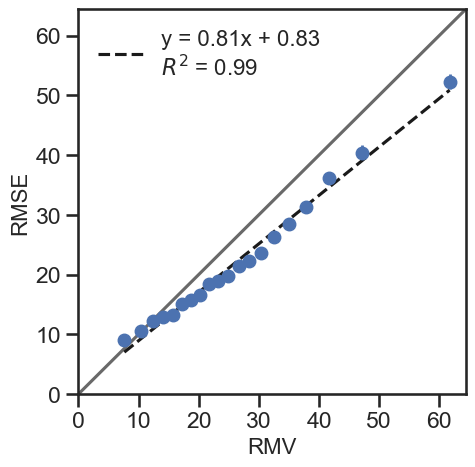

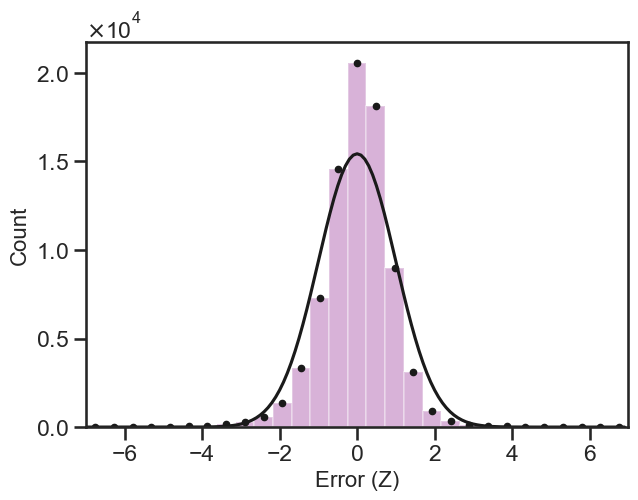

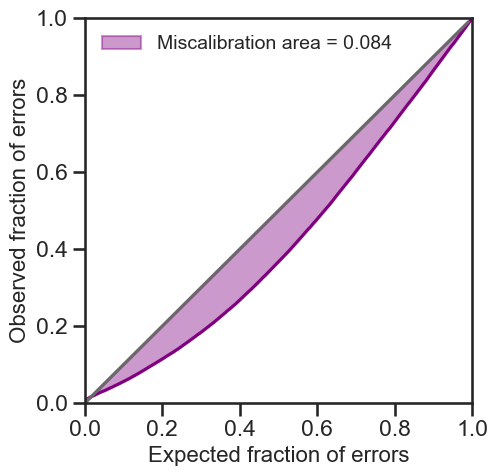

In [24]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [10]:
fig1.tight_layout()
fig1.savefig('figures/elec_RF_RF_DT_std_slope_metric.pdf')

fig2.tight_layout()
fig2.savefig('figures/elec_RF_RF_DT_std_Z_scores.pdf')

fig3.tight_layout()
fig3.savefig('figures/elec_RF_RF_DT_std_calibration_curve.pdf')

In [203]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.45
NLL = 4.45


### 1KNNdistsP1

In [207]:
sigmas = df['1KNNdistsP1']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
61882,0.0,1.322487,inf
76829,0.0,4.884029,inf


miscalibration area = 0.49
R-squared: 0.8186211909524808
Intercept: 19.621909997677665
Slope: 19.784202826595678


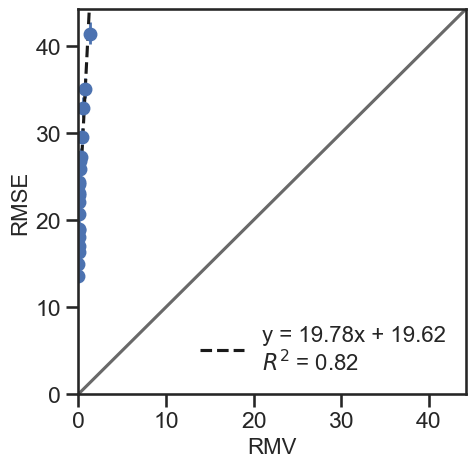

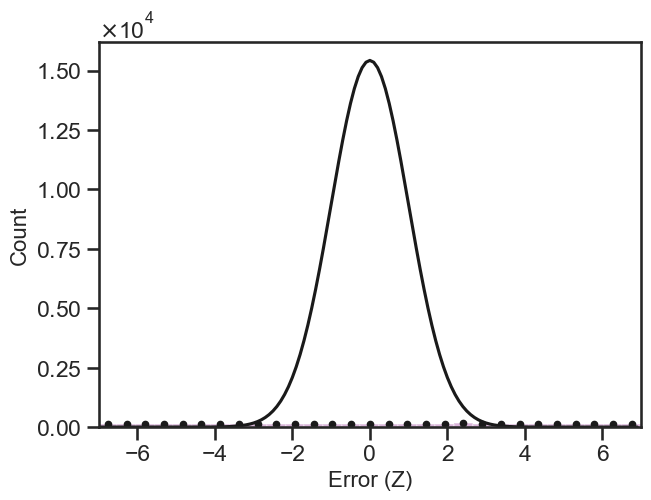

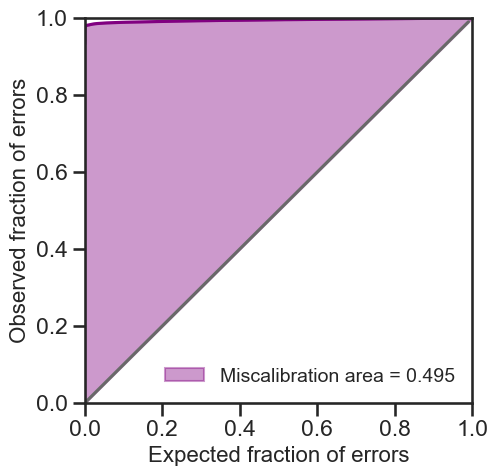

In [208]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [209]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')

rho_rank = 0.29


### 1KNNdistsP2

In [210]:
sigmas = df['1KNNdistsP2']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
61882,0.0,1.322487,inf
76829,0.0,4.884029,inf


miscalibration area = 0.50
R-squared: 0.8501082662865888
Intercept: 19.140997847616216
Slope: 54.68463810663989


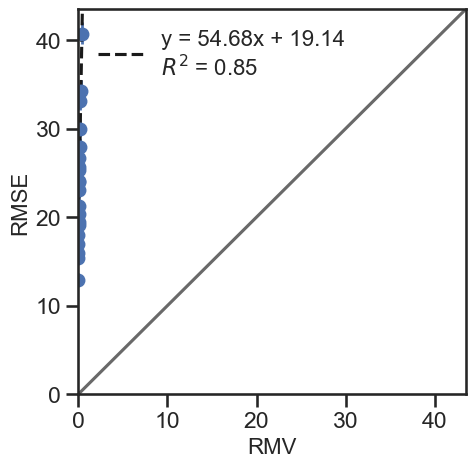

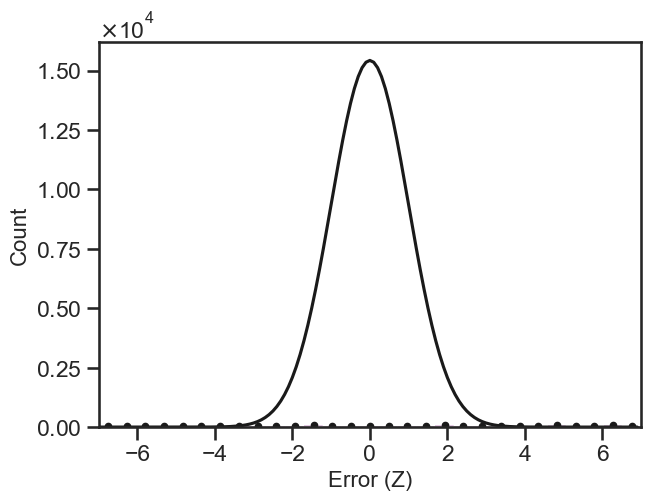

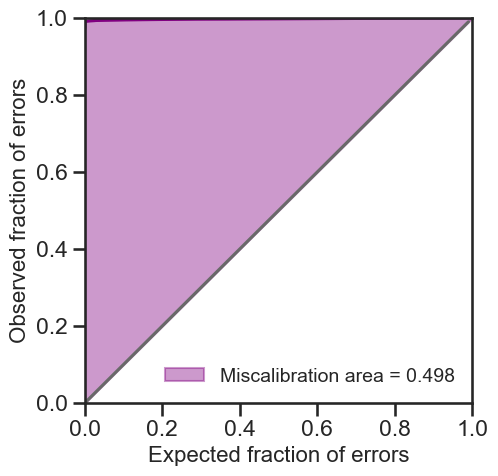

In [211]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [212]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')

rho_rank = 0.28


### 10KNNdistsP1

In [213]:
sigmas = df['10KNNdistsP1']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
70714,0.001354,-4.316561,3188.006726
61524,0.001510,6.624410,4387.026626


miscalibration area = 0.49
R-squared: 0.958234461235172
Intercept: 18.82788266400552
Slope: 13.359312865291264


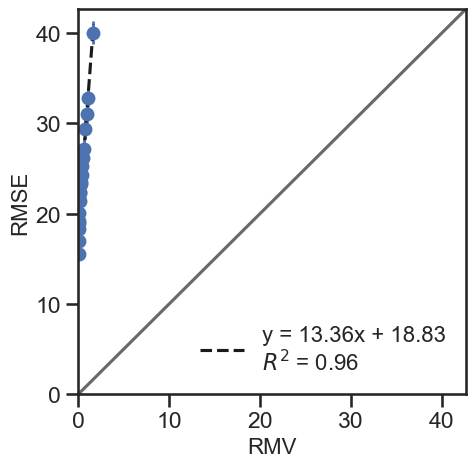

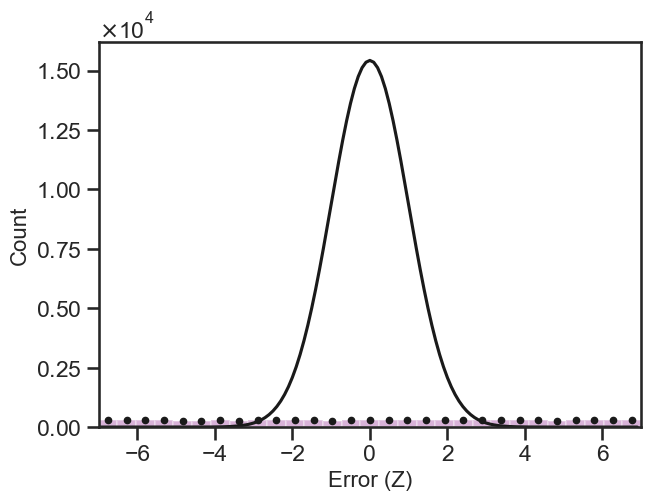

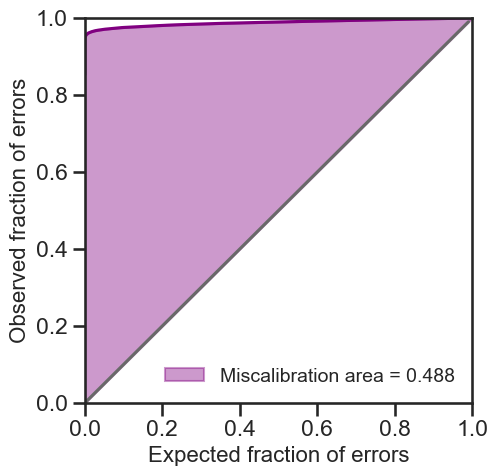

In [214]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [215]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.24
NLL = 125471.03


### 10KNNdistsP2

In [216]:
sigmas = df['10KNNdistsP2']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
70714,0.000499,-4.316561,8643.844465
1101,0.000555,-9.840216,17721.111838


miscalibration area = 0.50
R-squared: 0.9670147130927024
Intercept: 18.3745035738445
Slope: 37.153619205649946


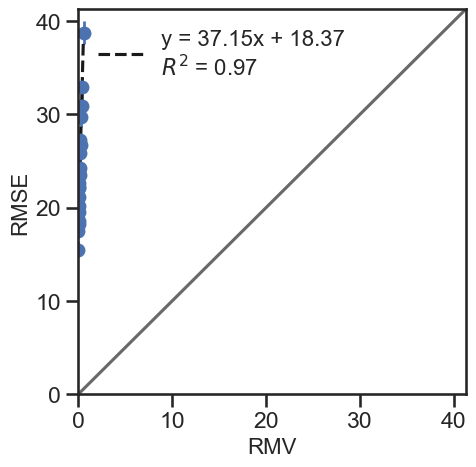

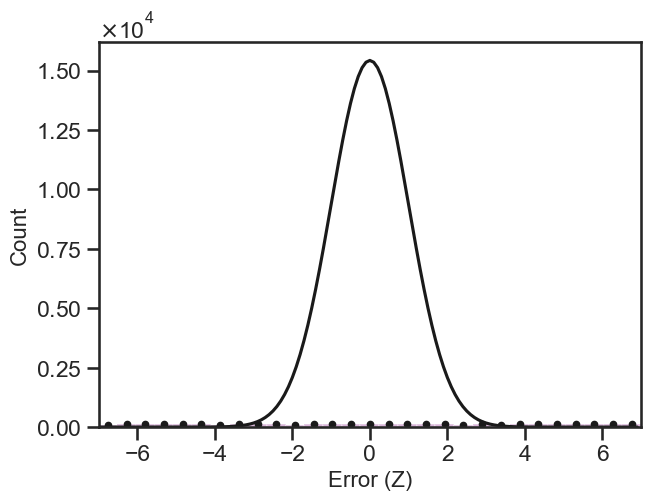

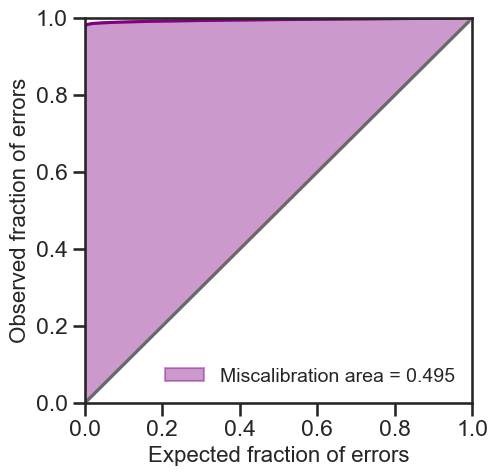

In [217]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [218]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.23
NLL = 735035.43


### Pred. std

In [219]:
sigmas = np.std(list(zip(df['Y_pred'], df['Y_pred_RF'], df['Y_pred_1KNN'], df['Y_pred_10KNN'])), ddof=1, axis=1)
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
5687,0.116009,9.843163,84.848128
67939,0.152290,11.755308,77.190301


miscalibration area = 0.13
R-squared: 0.9605106567192672
Intercept: 12.625098765848625
Slope: 0.6867883777001114


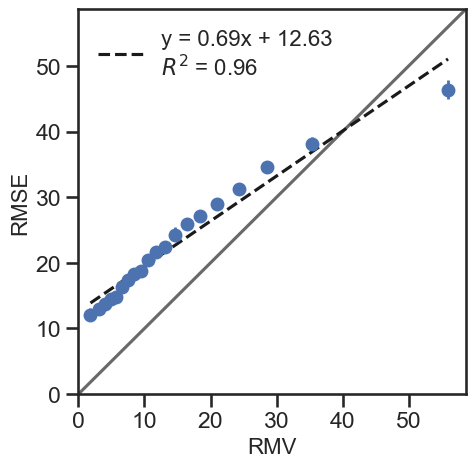

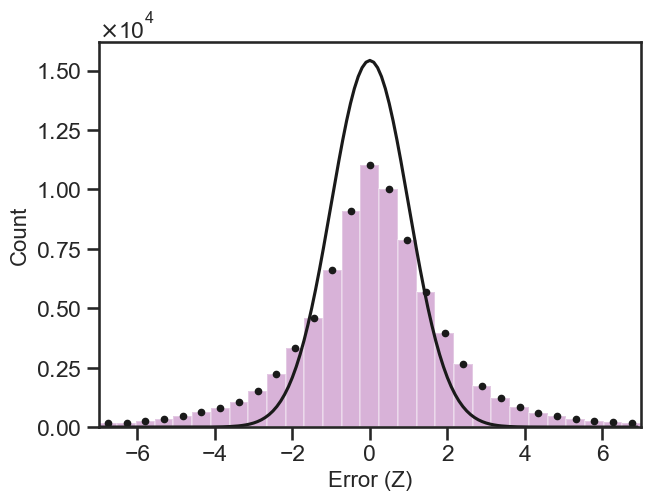

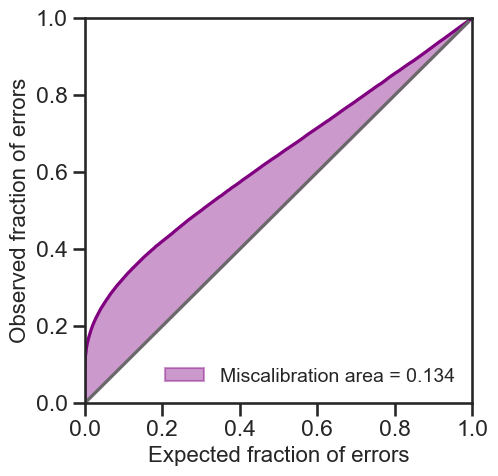

In [220]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [221]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.37
NLL = 8.29
